In [ ]:
!pip install datasets
!nvidia-smi

  Using cached huggingface_hub-0.26.2-py3-none-any.whl.metadata (13 kB)
Using cached huggingface_hub-0.26.2-py3-none-any.whl (447 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.14.1
    Uninstalling huggingface-hub-0.14.1:
      Successfully uninstalled huggingface-hub-0.14.1
Wed Nov 20 08:46:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA

**DOWNLOAD DATA**
___________________________________________________________________________

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("balraj98/monet2photo")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/balraj98/monet2photo/versions/5


**IMPORT PACKAGE**
___________________________________________________________________________

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.utils import save_image
from tqdm.notebook import tqdm
from PIL import Image
# import torch.nn.functional as F

**LOAD AND PREPROCESSING IMAGES**
___________________________________________________________________________

In [ ]:
# mengetahui list dir path
import os
import sys
print(os.listdir(path+"/trainA"))
print(os.listdir(path+"/trainB"))
IMAGE_SIZE = 256

['01118.jpg', '01013.jpg', '00145.jpg', '00202.jpg', '00025.jpg', '01189.jpg', '00962.jpg', '00292.jpg', '00333.jpg', '01263.jpg', '00746.jpg', '00224.jpg', '00906.jpg', '01148.jpg', '01281.jpg', '00157.jpg', '00362.jpg', '00397.jpg', '01014.jpg', '00867.jpg', '00004.jpg', '00285.jpg', '01025.jpg', '00862.jpg', '00722.jpg', '00432.jpg', '00631.jpg', '00011.jpg', '00012.jpg', '00693.jpg', '00429.jpg', '00196.jpg', '01155.jpg', '00501.jpg', '00895.jpg', '00031.jpg', '01242.jpg', '00485.jpg', '01255.jpg', '00006.jpg', '00948.jpg', '00863.jpg', '01137.jpg', '00789.jpg', '00967.jpg', '00381.jpg', '00178.jpg', '01288.jpg', '01015.jpg', '00233.jpg', '01157.jpg', '00602.jpg', '00209.jpg', '00469.jpg', '00453.jpg', '00778.jpg', '00198.jpg', '01138.jpg', '01023.jpg', '00273.jpg', '01136.jpg', '01147.jpg', '01028.jpg', '00833.jpg', '01302.jpg', '00505.jpg', '00052.jpg', '00249.jpg', '01225.jpg', '00925.jpg', '00864.jpg', '00129.jpg', '00687.jpg', '00874.jpg', '00112.jpg', '00557.jpg', '01227.jpg'

In [ ]:
import kagglehub
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Download dataset using KaggleHub
path = kagglehub.dataset_download("balraj98/monet2photo")
print("Dataset downloaded to:", path)
path_to_dataset_X = os.path.join(path, "trainA")
path_to_dataset_Y = os.path.join(path, "trainB")

# Check if dataset paths exist
if not os.path.exists(path_to_dataset_X) or not os.path.exists(path_to_dataset_Y):
    print(f"Path to dataset_X: {path_to_dataset_X}")
    print(f"Path to dataset_Y: {path_to_dataset_Y}")
    raise FileNotFoundError("Dataset not found in the expected path.")

# Dataset class
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(img_dir) if f.lower().endswith(("jpg", "jpeg", "png"))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

def normalize_img(img):
    return (img * 2.0) - 1.0

# Define transformations and data loader
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Higher resolution for better quality
    transforms.ToTensor(),
])

batch_size = 8
dataset_X = CustomImageDataset(path_to_dataset_X, transform=transform)
dataset_Y = CustomImageDataset(path_to_dataset_Y, transform=transform)
dataloader_X = DataLoader(dataset_X, batch_size=batch_size, shuffle=True, num_workers=4)  # Use num_workers=0 for compatibility
dataloader_Y = DataLoader(dataset_Y, batch_size=batch_size, shuffle=True, num_workers=4)

print("DataLoader for dataset_X and dataset_Y created with batch size:", batch_size)


Dataset downloaded to: /root/.cache/kagglehub/datasets/balraj98/monet2photo/versions/5
DataLoader for dataset_X and dataset_Y created with batch size: 8


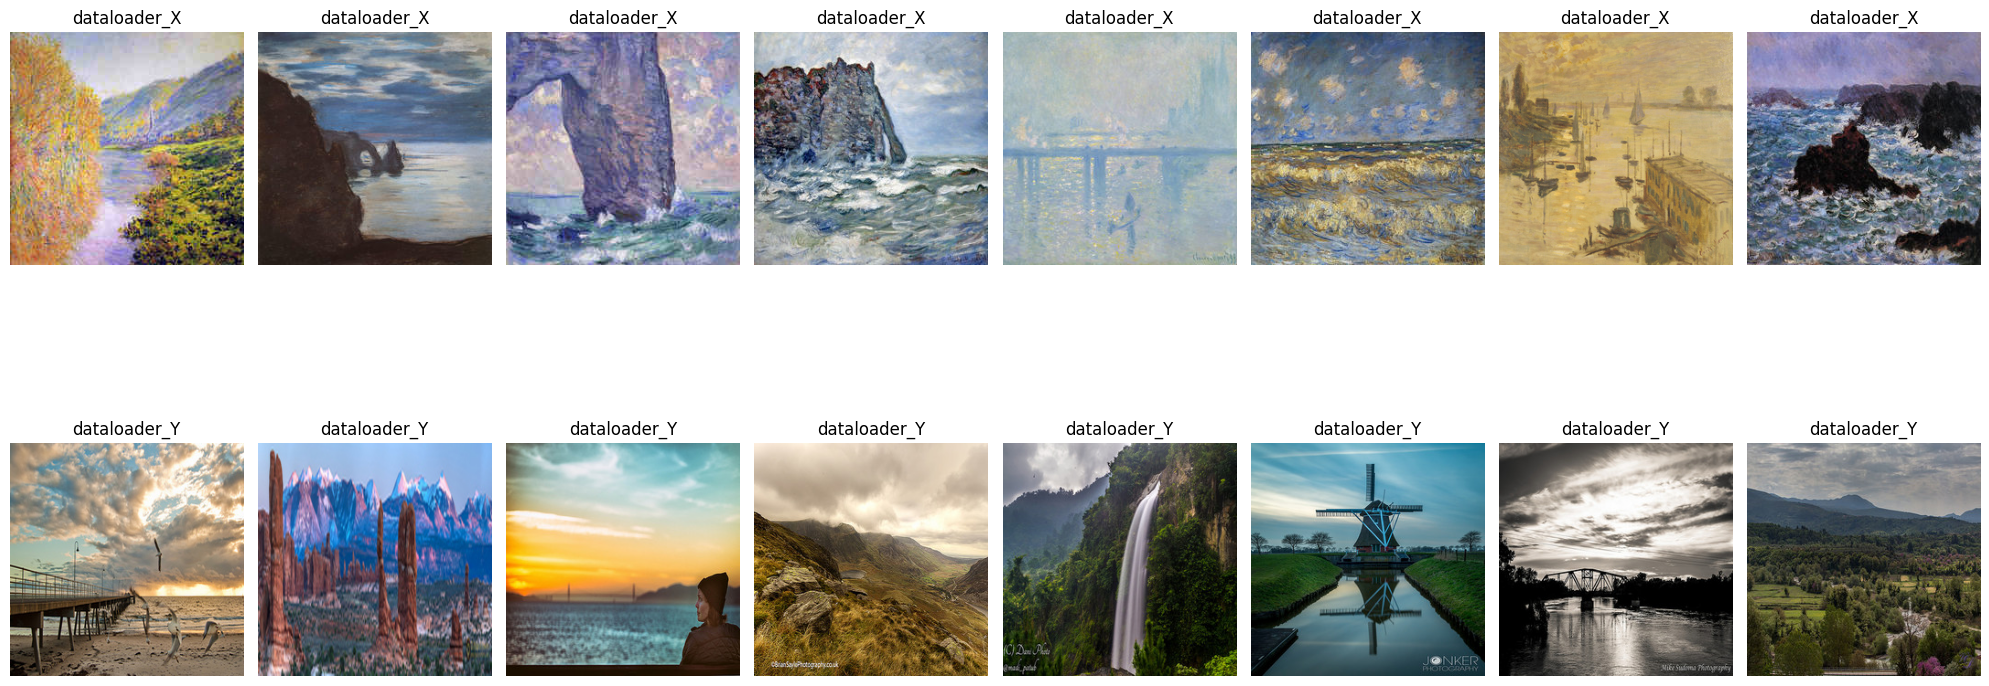

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of images from each dataloader
dataiter_X = iter(dataloader_X)
dataiter_Y = iter(dataloader_Y)
images_X = next(dataiter_X)
images_Y = next(dataiter_Y)

# Create a figure and a set of subplots
fig, axs = plt.subplots(2, batch_size, figsize=(20, 10))  # 2 rows for X and Y

# Display images from dataloader_X
for i in range(batch_size):
    axs[0, i].imshow(images_X[i].permute(1, 2, 0))  # Transpose to (H, W, C)
    axs[0, i].axis('off')  # Turn off axis labels
    axs[0, i].set_title('dataloader_X')  # Set title

# Display images from dataloader_Y
for i in range(batch_size):
    axs[1, i].imshow(images_Y[i].permute(1, 2, 0))  # Transpose to (H, W, C)
    axs[1, i].axis('off')  # Turn off axis labels
    axs[1, i].set_title('dataloader_Y')  # Set title

plt.tight_layout()  # Adjust layout for better spacing
plt.show()  # Show the figure

**MODELLING CYCLE GAN ARCHITECHTURE**
__________________________________________________________________________

In [ ]:
# Inisialisasi bobot sesuai metode yang sama
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): Jumlah epoch untuk menunggu sebelum menghentikan jika tidak ada peningkatan.
            min_delta (float): Peningkatan minimum untuk dianggap sebagai peningkatan.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, current_loss):
        if self.best_loss is None:
            self.best_loss = current_loss
        elif self.best_loss - current_loss > self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1 or classname.find('InstanceNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

# Instance normalization
class InstanceNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, affine=True):
        super(InstanceNorm, self).__init__()
        self.norm = nn.InstanceNorm2d(num_features, eps=eps, affine=affine)

    def forward(self, x):
        return self.norm(x)

# Encoder block
class EncodeBlock(nn.Module):
    def __init__(self, in_channels, out_channels, size=3, stride=2, apply_instancenorm=True):
        super(EncodeBlock, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=size, stride=stride, padding=size // 2, bias=False),
        ]
        if apply_instancenorm:
            layers.append(InstanceNorm(out_channels))
        layers.append(nn.ReLU(inplace=True))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

# Transformer block
class TransformBlock(nn.Module):
    def __init__(self, channels, size=3):
        super(TransformBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=size, stride=1, padding=size // 2, bias=False),
            InstanceNorm(channels),  # Menambahkan normalisasi
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=size, stride=1, padding=size // 2, bias=False),
            InstanceNorm(channels)  # Menambahkan normalisasi
        )

    def forward(self, x):
        return x + self.block(x)

# Decoder block
class DecodeBlock(nn.Module):
    def __init__(self, in_channels, out_channels, size=3, stride=2, apply_instancenorm=True):
        super(DecodeBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=size, stride=stride, padding=size // 2,
                               output_padding=stride - 1, bias=False),
        ]
        if apply_instancenorm:
            layers.append(InstanceNorm(out_channels))
        layers.append(nn.ReLU(inplace=True))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

# Generator model
class Generator(nn.Module):
    def __init__(self, input_channels=3, num_transformer_blocks=6):
        super(Generator, self).__init__()
        self.enc1 = EncodeBlock(input_channels, 64, size=7, stride=1, apply_instancenorm=False)
        self.enc2 = EncodeBlock(64, 128, size=3, stride=2)
        self.enc3 = EncodeBlock(128, 256, size=3, stride=2)

        self.transformer = nn.Sequential(
            *[TransformBlock(256) for _ in range(num_transformer_blocks)]
        )

        self.dec1 = DecodeBlock(256, 128, size=3, stride=2)
        self.dec2 = DecodeBlock(128, 64, size=3, stride=2)
        self.final = nn.Conv2d(64, input_channels, kernel_size=7, stride=1, padding=3)
        self.tanh = nn.Tanh()

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        x = self.transformer(enc3)
        x = self.dec1(x)
        x = self.dec2(x)
        x = self.final(x)
        return self.tanh(x)

# Discriminator model
class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            EncodeBlock(input_channels, 64, size=4, stride=2, apply_instancenorm=False),
            EncodeBlock(64, 128, size=4, stride=2),
            EncodeBlock(128, 256, size=4, stride=2),
            EncodeBlock(256, 512, size=4, stride=1),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0)
        )

    def forward(self, x):
        return self.model(x)

**CYCLE GAN ARCHITECHTURE SETTING**
__________________________________________________________________________

In [ ]:
# Re-run instantiation of models and optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G_XtoY = Generator().to(device)
G_YtoX = Generator().to(device)
D_X = Discriminator().to(device)
D_Y = Discriminator().to(device)

lr = 0.0002
optimizer_G = optim.Adam(list(G_XtoY.parameters()) + list(G_YtoX.parameters()), lr=lr, betas=(0.5, 0.999))
optimizer_D_X = optim.Adam(D_X.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_Y = optim.Adam(D_Y.parameters(), lr=lr, betas=(0.5, 0.999))
adversarial_loss = nn.MSELoss()
cycle_consistency_loss = nn.L1Loss()
identity_loss = nn.L1Loss()

In [ ]:
from torchvision.utils import make_grid

# Fungsi untuk menampilkan gambar hasil
def visualize_results(real_Y, fake_X, epoch):
    real_Y = (real_Y * 0.5 + 0.5).clamp(0, 1)  # Normalize to [0, 1]
    fake_X = (fake_X * 0.5 + 0.5).clamp(0, 1)  # Normalize to [0, 1]

    # Buat grid gambar
    grid_real = make_grid(real_Y, nrow=5)  # Baris atas (Real_Y)
    grid_fake = make_grid(fake_X, nrow=5)  # Baris bawah (Fake_X)

    # Gabungkan gambar
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    ax[0].imshow(grid_real.permute(1, 2, 0).cpu().numpy())
    ax[0].axis("off")
    ax[0].set_title(f"Real_Y - Epoch {epoch + 1}")
    ax[1].imshow(grid_fake.permute(1, 2, 0).cpu().numpy())
    ax[1].axis("off")
    ax[1].set_title(f"Generated Fake_X - Epoch {epoch + 1}")
    plt.tight_layout()
    plt.show()

In [ ]:
# Loop pelatihan CycleGAN
early_stopping = EarlyStopping(patience=10, min_delta=0.001)
loss_records = []
num_epochs = 100
for epoch in range(num_epochs):
    for i, (real_X, real_Y) in enumerate(zip(dataloader_X, dataloader_Y)):
        real_X = real_X.to(device)
        real_Y = real_Y.to(device)

        # ----------------------
        #  Pelatihan Generator
        # ----------------------
        fake_Y = G_XtoY(real_X)
        reconstructed_X = G_YtoX(fake_Y)
        fake_X = G_YtoX(real_Y)
        reconstructed_Y = G_XtoY(fake_X)

        # Loss Generator
        loss_G_XtoY = adversarial_loss(D_Y(fake_Y), torch.ones_like(D_Y(fake_Y)))
        loss_G_YtoX = adversarial_loss(D_X(fake_X), torch.ones_like(D_X(fake_X)))
        loss_cycle_X = cycle_consistency_loss(reconstructed_X, real_X)
        loss_cycle_Y = cycle_consistency_loss(reconstructed_Y, real_Y)
        loss_G = loss_G_XtoY + loss_G_YtoX + 10.0 * (loss_cycle_X + loss_cycle_Y)

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        # ----------------------
        #  Pelatihan Discriminator
        # ----------------------
        # Discriminator D_X
        loss_D_X_real = adversarial_loss(D_X(real_X), torch.ones_like(D_X(real_X)))
        loss_D_X_fake = adversarial_loss(D_X(fake_X.detach()), torch.zeros_like(D_X(fake_X)))
        loss_D_X = (loss_D_X_real + loss_D_X_fake) / 2

        optimizer_D_X.zero_grad()
        loss_D_X.backward()
        optimizer_D_X.step()

        # Discriminator D_Y
        loss_D_Y_real = adversarial_loss(D_Y(real_Y), torch.ones_like(D_Y(real_Y)))
        loss_D_Y_fake = adversarial_loss(D_Y(fake_Y.detach()), torch.zeros_like(D_Y(fake_Y)))
        loss_D_Y = (loss_D_Y_real + loss_D_Y_fake) / 2

        optimizer_D_Y.zero_grad()
        loss_D_Y.backward()
        optimizer_D_Y.step()

    # Logging hasil setiap epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss_G: {loss_G.item():.4f}, "
          f"Loss_D_X: {loss_D_X.item():.4f}, Loss_D_Y: {loss_D_Y.item():.4f}")
    loss_records.append({
        'epoch': epoch + 1,
        'Loss_G': loss_G.item(),
        'Loss_D_X': loss_D_X.item(),
        'Loss_D_Y': loss_D_Y.item()
    })
    # ----------------------
    # Visualisasi hasil
    # ----------------------
    fake_X = G_YtoX(real_Y)  # Hasil dari generator (Y -> X)
    visualize_results(real_Y[:5], fake_X[:5], epoch)  # Menampilkan 5 gambar pertama


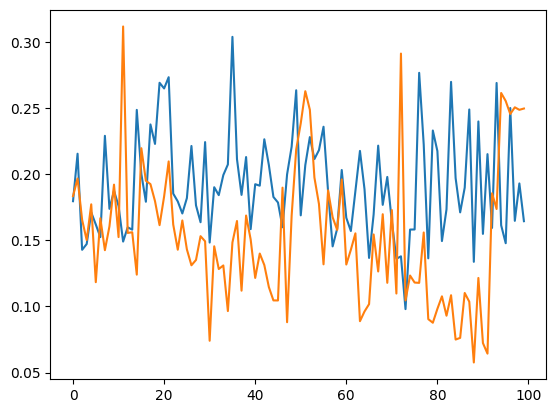

In [ ]:
# line plot for YtoX
plt.plot([record['Loss_D_Y'] for record in loss_records], label='Loss_D_Y')
plt.plot([record['Loss_D_X'] for record in loss_records], label='Loss_D_X')

In [ ]:
# install RealESRGAN_x4
!pip install git+https://github.com/sberbank-ai/Real-ESRGAN.git
!pip install huggingface_hub==0.14.1

  Cloning https://github.com/sberbank-ai/Real-ESRGAN.git to /tmp/pip-req-build-oua8lfb3
  Running command git clone --filter=blob:none --quiet https://github.com/sberbank-ai/Real-ESRGAN.git /tmp/pip-req-build-oua8lfb3
  Resolved https://github.com/sberbank-ai/Real-ESRGAN.git to commit 362a0316878f41dbdfbb23657b450c3353de5acf
  Preparing metadata (setup.py) ... done
  Using cached huggingface_hub-0.14.1-py3-none-any.whl.metadata (7.6 kB)
Using cached huggingface_hub-0.14.1-py3-none-any.whl (224 kB)
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.26.2
    Uninstalling huggingface-hub-0.26.2:
      Successfully uninstalled huggingface-hub-0.26.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
accelerate 1.1.1 requires huggingface-hub>=0.21.0, but you have huggingface-hub 0.14.1 which is incompatible.
datasets 3.1.0 requir

/usr/local/lib/python3.10/dist-packages/RealESRGAN/model.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast()
/usr/local/lib/python3.10/dist-packages/RealESRGAN/model.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for 

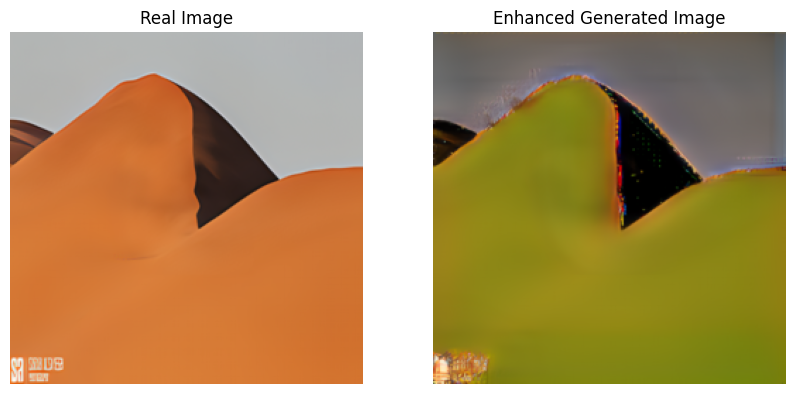

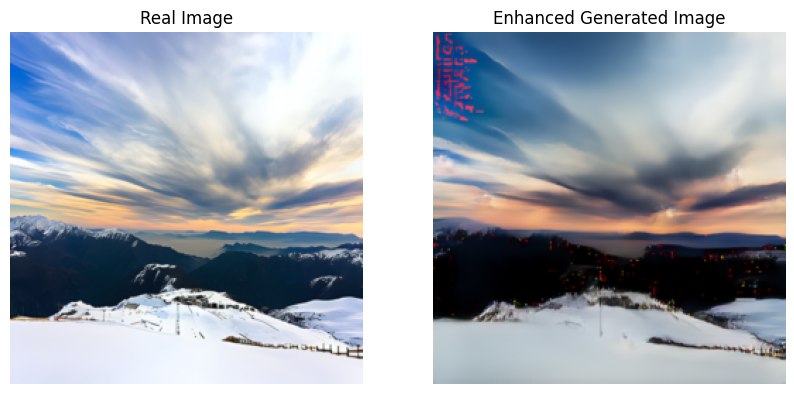

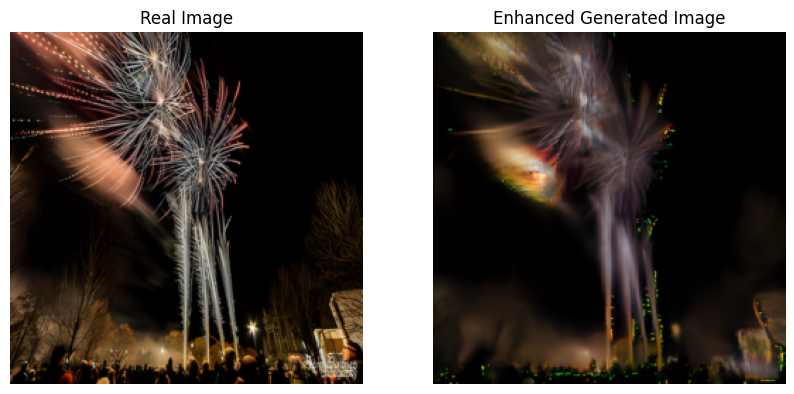

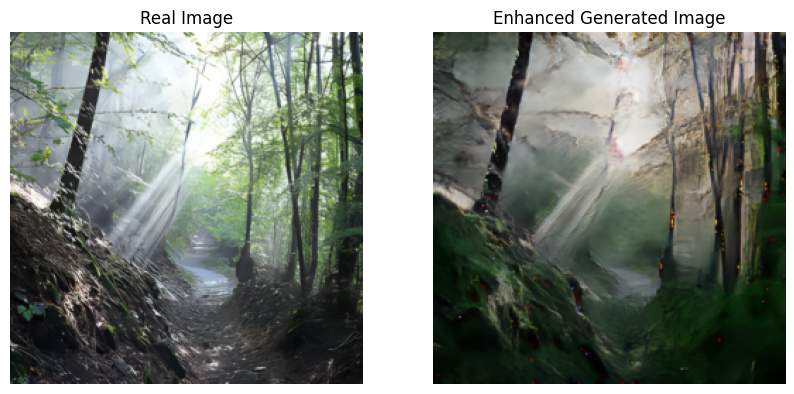

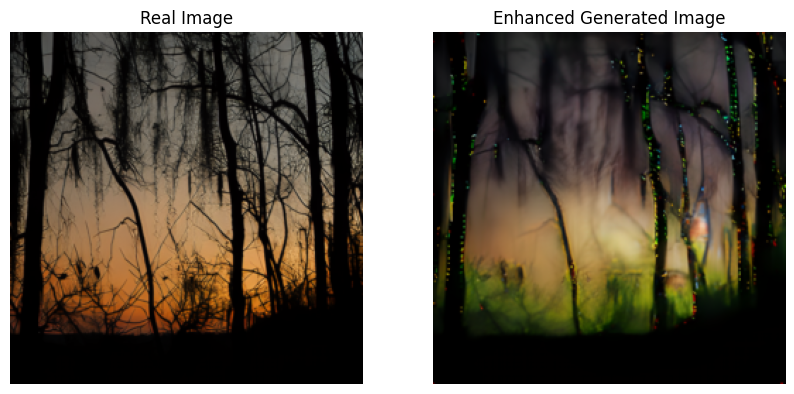

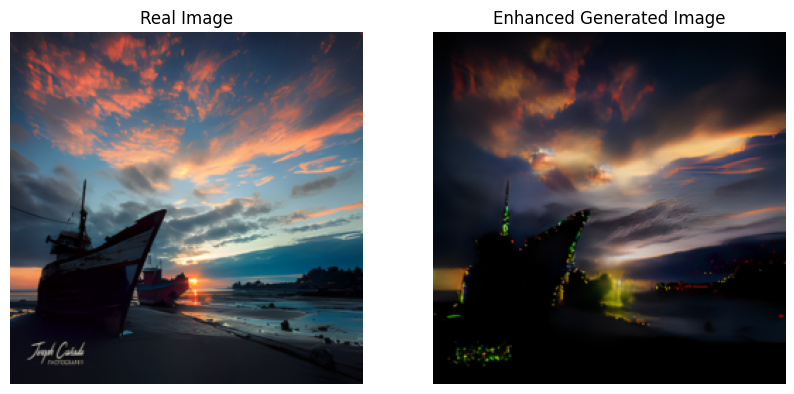

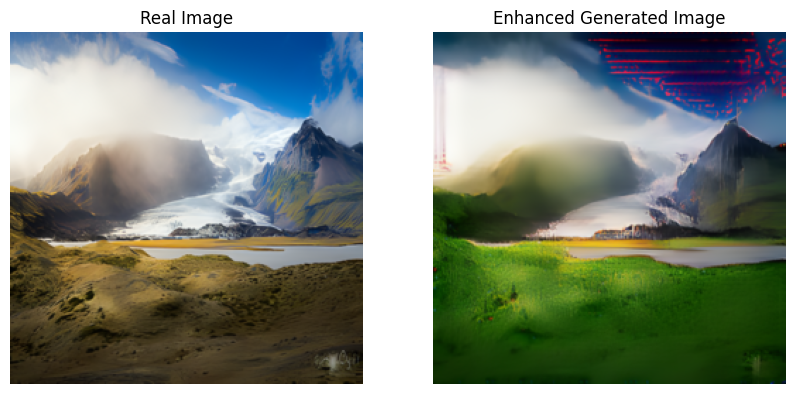

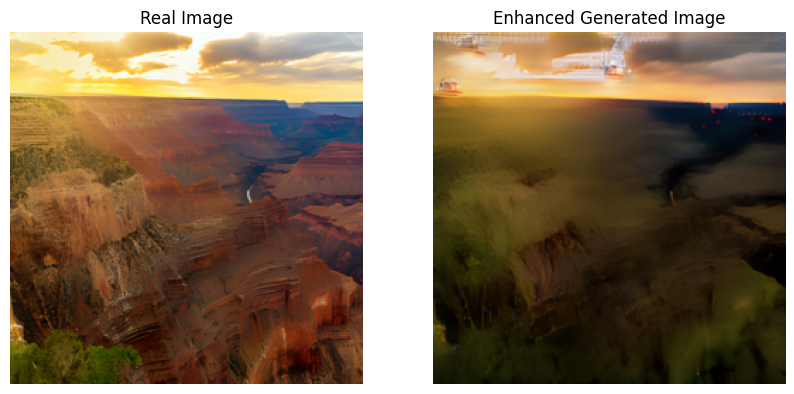

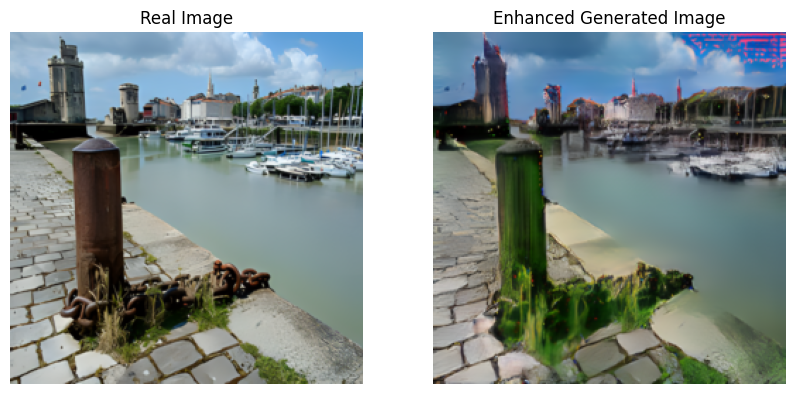

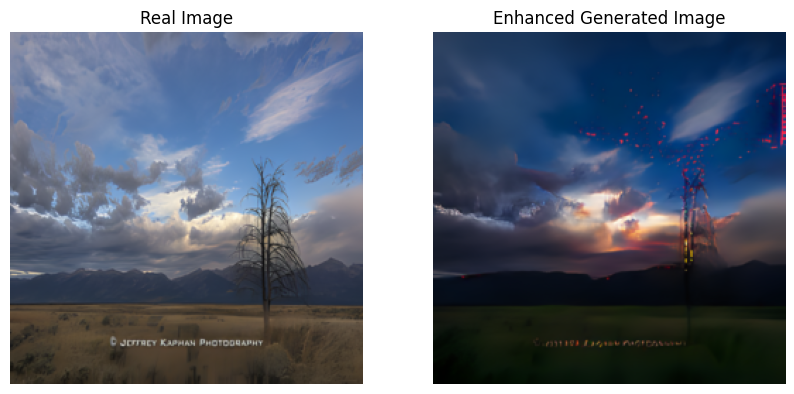

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision.transforms import ToPILImage, ToTensor, Resize
import matplotlib.pyplot as plt
import numpy as np
from RealESRGAN import RealESRGAN  # Pastikan RealESRGAN diinstal

# **Inisialisasi Real-ESRGAN**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sr_model = RealESRGAN(device, scale=4)  # 4x upscaling
sr_model.load_weights('weights/RealESRGAN_x4.pth', download=True)

# **Fungsi untuk meningkatkan resolusi gambar**
def enhance_image_with_realesrgan(image_tensor):
    """Tingkatkan resolusi gambar menggunakan Real-ESRGAN."""
    image_tensor = image_tensor.squeeze(0)  # Hilangkan dimensi batch
    pil_image = ToPILImage()(image_tensor.cpu())  # Konversi tensor ke PIL Image
    sr_image = sr_model.predict(pil_image)  # Tingkatkan resolusi
    return ToTensor()(sr_image).to(device)  # Kembali ke tensor

# **Fungsi untuk menampilkan gambar**
def show_generated_images(real_Y, fake_Y, size=(250, 250)):
    """Tampilkan gambar asli dan hasil yang ditingkatkan."""
    real_Y_enhanced = enhance_image_with_realesrgan(real_Y)
    fake_Y_enhanced = enhance_image_with_realesrgan(fake_Y)

    # Resize untuk tampilan
    resize = Resize(size)
    real_Y_resized = resize(real_Y_enhanced).cpu().detach().numpy()
    fake_Y_resized = resize(fake_Y_enhanced).cpu().detach().numpy()

    # Pastikan format [H, W, C]
    if real_Y_resized.ndim == 3:
        real_Y_resized = real_Y_resized.transpose(1, 2, 0)  # [C, H, W] -> [H, W, C]
    if fake_Y_resized.ndim == 3:
        fake_Y_resized = fake_Y_resized.transpose(1, 2, 0)  # [C, H, W] -> [H, W, C]

    # Tampilkan gambar
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(np.clip(real_Y_resized, 0, 1))
    axs[0].set_title("Real Image")
    axs[0].axis('off')
    axs[1].imshow(np.clip(fake_Y_resized, 0, 1))
    axs[1].set_title("Enhanced Generated Image")
    axs[1].axis('off')
    plt.show()

# **Contoh penggunaan dalam loop training**
for epoch in range(10):  # Loop training satu epoch untuk demo
    for i, real_Y in enumerate(dataloader_Y):
        real_Y = real_Y.to(device)
        fake_Y = G_XtoY(real_Y)  # Hasil dari generator

        # Pilih batch pertama untuk ditampilkan
        if i == 0:
            show_generated_images(real_Y[0].unsqueeze(0), fake_Y[0].unsqueeze(0))
            break


In [ ]:
# Simpan parameter model
torch.save(G_XtoY.state_dict(), "G_XtoY.pth")
torch.save(G_YtoX.state_dict(), "G_YtoX.pth")
torch.save(D_X.state_dict(), "D_X.pth")
torch.save(D_Y.state_dict(), "D_Y.pth")

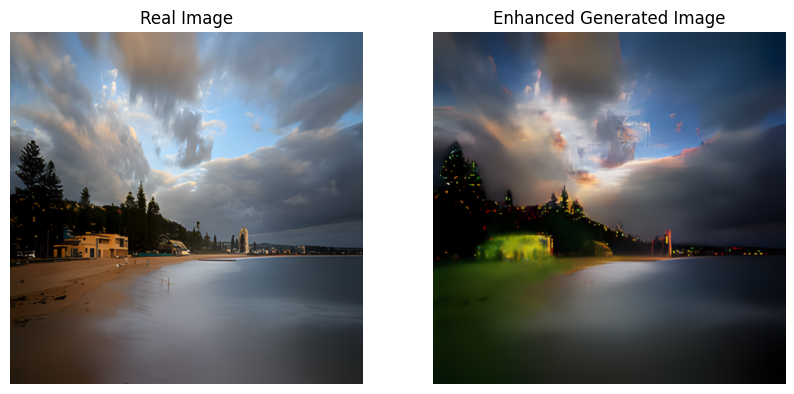

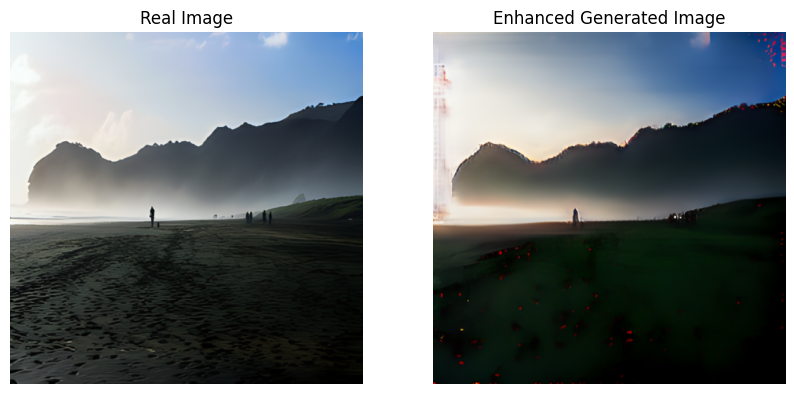

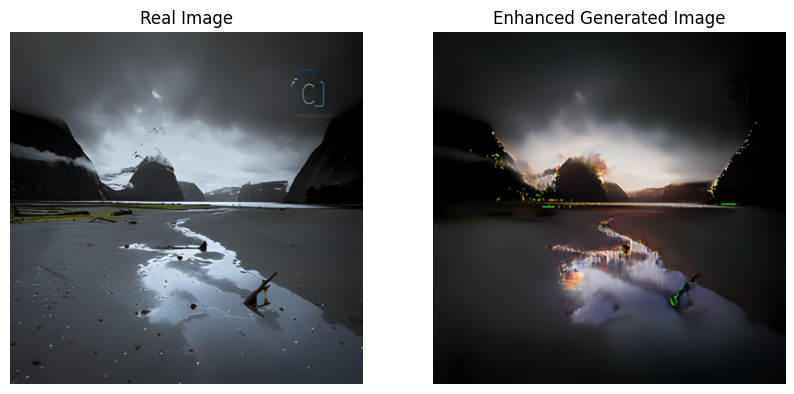

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision.transforms import ToPILImage, ToTensor, Resize
import matplotlib.pyplot as plt
import numpy as np
from RealESRGAN import RealESRGAN  # Pastikan RealESRGAN diinstal

# **Inisialisasi Real-ESRGAN**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sr_model = RealESRGAN(device, scale=4)  # 4x upscaling
sr_model.load_weights('weights/RealESRGAN_x4.pth', download=True)

# **Fungsi untuk meningkatkan resolusi gambar**
def enhance_image_with_realesrgan(image_tensor):
    """Tingkatkan resolusi gambar menggunakan Real-ESRGAN."""
    image_tensor = image_tensor.squeeze(0)  # Hilangkan dimensi batch
    pil_image = ToPILImage()(image_tensor.cpu())  # Konversi tensor ke PIL Image
    sr_image = sr_model.predict(pil_image)  # Tingkatkan resolusi
    return ToTensor()(sr_image).to(device)  # Kembali ke tensor

# **Fungsi untuk menampilkan gambar**
def show_generated_images(real_Y, fake_Y, size=(500, 500)):
    """Tampilkan gambar asli dan hasil yang ditingkatkan."""
    real_Y_enhanced = enhance_image_with_realesrgan(real_Y)
    fake_Y_enhanced = enhance_image_with_realesrgan(fake_Y)

    # Resize untuk tampilan
    resize = Resize(size)
    real_Y_resized = resize(real_Y_enhanced).cpu().detach().numpy()
    fake_Y_resized = resize(fake_Y_enhanced).cpu().detach().numpy()

    # Pastikan format [H, W, C]
    if real_Y_resized.ndim == 3:
        real_Y_resized = real_Y_resized.transpose(1, 2, 0)  # [C, H, W] -> [H, W, C]
    if fake_Y_resized.ndim == 3:
        fake_Y_resized = fake_Y_resized.transpose(1, 2, 0)  # [C, H, W] -> [H, W, C]

    # Tampilkan gambar
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(np.clip(real_Y_resized, 0, 1))
    axs[0].set_title("Real Image")
    axs[0].axis('off')
    axs[1].imshow(np.clip(fake_Y_resized, 0, 1))
    axs[1].set_title("Enhanced Generated Image")
    axs[1].axis('off')
    plt.show()

# **Contoh penggunaan dalam loop training**
for epoch in range(3):  # Loop training satu epoch untuk demo
    for i, real_Y in enumerate(dataloader_Y):
        real_Y = real_Y.to(device)
        fake_Y = G_XtoY(real_Y)  # Hasil dari generator

        # Pilih batch pertama untuk ditampilkan
        if i == 0:
            show_generated_images(real_Y[0].unsqueeze(0), fake_Y[0].unsqueeze(0))
            break


In [ ]:
real_X[0].unsqueeze(0).cpu().detach().numpy().shape

(1, 3, 256, 256)

**LOAD MODEL**
__________________________________________________________________________

In [ ]:
load_model = Generator(input_channels=3).to(device)
load_model.load_state_dict(torch.load("/content/G_YtoX.pth", map_location=device))
load_model.eval()


<ipython-input-17-7c946fde55db>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model.load_state_dict(torch.load("/content/G_YtoX.pth", map_location=device))


Generator(
  (enc1): EncodeBlock(
    (block): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (1): ReLU(inplace=True)
    )
  )
  (enc2): EncodeBlock(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm(
        (norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      )
      (2): ReLU(inplace=True)
    )
  )
  (enc3): EncodeBlock(
    (block): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm(
        (norm): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      )
      (2): ReLU(inplace=True)
    )
  )
  (transformer): Sequential(
    (0): TransformBlock(
      (block): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): I

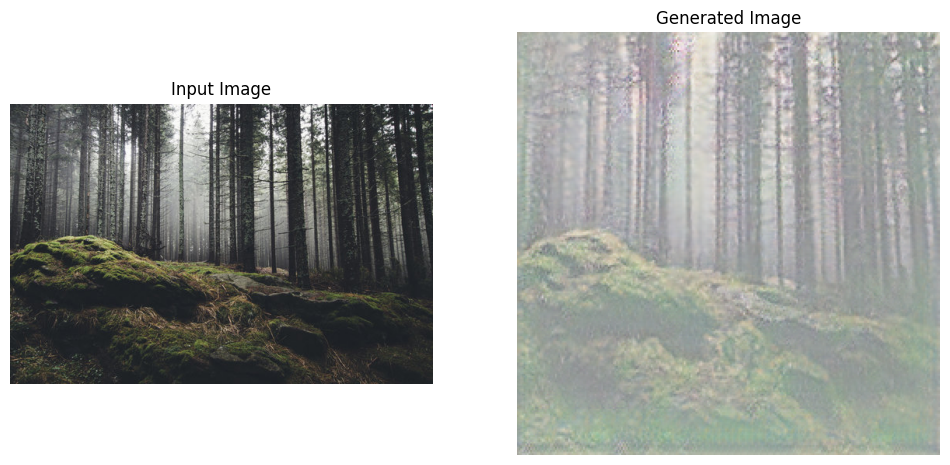

In [ ]:
input_image = Image.open("/content/360_F_78894153_6vehwXxxFzCbIyFjmZdrtoqxk219gWnd.jpg").convert("RGB")
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to model input size
    transforms.ToTensor(),          # Convert image to tensor
])
input_tensor = transform(input_image).unsqueeze(0).to(device)

# Generate the output image using the model
with torch.no_grad():
    generated_tensor = load_model(input_tensor)

# Post-process the generated image for visualization
generated_image = generated_tensor.squeeze(0).cpu().detach().numpy()
generated_image = (generated_image * 0.5 + 0.5).transpose(1, 2, 0)  # Denormalize and reorder channels

# Display the input and generated images
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(input_image)
axs[0].set_title("Input Image")
axs[0].axis('off')

axs[1].imshow(np.clip(generated_image, 0, 1))
axs[1].set_title("Generated Image")
axs[1].axis('off')
plt.show()